<h1>Base Matrix Factorization Recommender System</h1>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import math
from models.BaseCFModel import BaseCFModel
from tensorflow.keras.layers import Input, Embedding, Flatten
from sklearn.model_selection import train_test_split

In [2]:
DATA_PATH = '../data/ml-latest-small'

In [3]:
ratings_matrix = pd.read_csv(f'{DATA_PATH}/ratings.csv')
ratings_matrix.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
dict_movies = {}
count = 1
for _id in sorted(np.unique(ratings_matrix.movieId)):
    if _id not in dict_movies.keys():
        dict_movies[_id] = count
        count += 1        

In [5]:
ratings_matrix = ratings_matrix.replace({'movieId': dict_movies})

In [6]:
N_USERS = len(np.unique(ratings_matrix['userId']))
N_MOVIES = len(np.unique(ratings_matrix['movieId']))

In [7]:
print(f'Number of users in the data set: {N_USERS} \nNumber of movies in the data set: {N_MOVIES}')

Number of users in the data set: 610 
Number of movies in the data set: 9724


In [8]:
ratings_matrix

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,44,5.0,964983815
4,1,47,5.0,964982931
...,...,...,...,...
100831,610,9417,4.0,1493848402
100832,610,9444,5.0,1493850091
100833,610,9445,5.0,1494273047
100834,610,9446,5.0,1493846352


In [9]:
LATENT_FACTORS = 10

In [10]:
model = BaseCFModel(N_USERS, N_MOVIES, LATENT_FACTORS)

In [11]:
model.compile()

Model: "MatrixFactorizationReccomender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MoviesInput (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
UsersInput (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
MoviesEmbedding (Embedding)     (None, 1, 10)        97250       MoviesInput[0][0]                
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 10)        6110        UsersInput[0][0]                 
_____________________________________________________________________

In [12]:
train_data, test_data = train_test_split(ratings_matrix,
                                         test_size = 0.2, 
                                         random_state = 0)

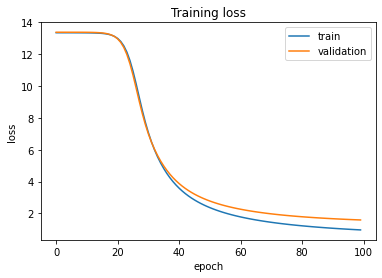

In [13]:
model.train(train_data, epochs = 100, batch = 32)

In [14]:
model.model.save('./trained_models/base')

INFO:tensorflow:Assets written to: ./trained_models/base\assets


INFO:tensorflow:Assets written to: ./trained_models/base\assets


In [15]:
model = tf.keras.models.load_model('./trained_models/base')

In [16]:
movie_embeddings = model.get_layer(name='MoviesEmbedding').get_weights()

In [17]:
movie_embeddings_frame = pd.DataFrame(movie_embeddings[0])

In [18]:
movie_embeddings_frame['movieId'] = [0] + list(dict_movies.values())

In [20]:
movie_embeddings_frame.to_csv(f'../results/movie_embeddings_{LATENT_FACTORS}_latent_factors.csv')

In [21]:
movies_data = pd.read_csv(f'{DATA_PATH}/movies.csv')
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
USER_ID = 5
num_movies = 3

In [28]:
user_embedding_learnt = model.get_layer(name='UsersEmbedding').get_weights()[0][USER_ID]
movie_embedding_learnt = model.get_layer(name='MoviesEmbedding').get_weights()[0]
movies = user_embedding_learnt @ movie_embedding_learnt.T
recommendations = np.argpartition(movies, -num_movies)[-num_movies:]
print(recommendations)

[ 47 511 278]


In [29]:
reverse_dict_movies = {}
for item in dict_movies.items():
    reverse_dict_movies[item[1]] = item[0]

In [33]:
recommended_movies_ids = []
for val in recommendations:
    recommended_movies_ids.append(reverse_dict_movies[val])

In [35]:
movies_data[movies_data.movieId.isin(recommended_movies_ids)]

,movieId,title,genres
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
